### Exploring PHS_O2 term from the model

In [9]:
import xarray as xr
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cm
from salishsea_tools import visualisations as vis
import plotly
from IPython.display import display, HTML
plotly.offline.init_notebook_mode()
display(HTML(
    '<script type="text/javascript" async src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/MathJax.js?config=TeX-MML-AM_SVG"></script>'
))
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
import arrow

In [2]:
bathy = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc','r')
mesh = nc.Dataset('/ocean/atall/MOAD/grid/mesh_mask202108.nc')
depth = mesh.variables['gdept_0'][:]
thalweg_HC = '/ocean/atall/MOAD/analysis-abdoul/notebooks/thalweg_work/thalweg_files/JoseTallthalwegPS.txt' 
thalweg_SoG = '/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt'
thalweg_ptsSoG = np.loadtxt(thalweg_SoG, delimiter=' ', dtype=int)
thalweg_ptsHC = np.loadtxt(thalweg_HC, delimiter=' ', dtype=int)
thalwegs =list([thalweg_ptsSoG,thalweg_ptsHC[::-1]])
depmin = list([450,170])

In [3]:
dir='/ocean/atall/MOAD/Model/month-avg.202410/all_years/'
#dir='/ocean/atall/MOAD/Model/month-avg.202410/2015_2020/'

In [4]:
ds_chem= xr.open_mfdataset(f'{dir}SalishSeaCast_1m_chem_T_20*', concat_dim="month", combine="nested",
                data_vars='minimal', coords='minimal', compat='override', autoclose=True, parallel=True)
ds_chem_clim = ds_chem.groupby(ds_chem.month).mean(dim='month')
ds_biol= xr.open_mfdataset(f'{dir}SalishSeaCast_1m_biol_T_20*', concat_dim="month", combine="nested",
                data_vars='minimal', coords='minimal', compat='override', autoclose=True, parallel=True)
ds_biol_clim = ds_biol.groupby(ds_chem.month).mean(dim='month')
ds_grdT= xr.open_mfdataset(f'{dir}SalishSeaCast_1m_grid_T_20*', concat_dim="month", combine="nested",
                data_vars='minimal', coords='minimal', compat='override', autoclose=True, parallel=True)
ds_grdT_clim = ds_grdT.groupby(ds_grdT.month).mean(dim='month')
ds_diag= xr.open_mfdataset(f'{dir}SalishSeaCast_1m_diag_T_20*', concat_dim="month", combine="nested",
                data_vars='minimal', coords='minimal', compat='override', autoclose=True, parallel=True) 
ds_diag_clim = ds_diag.groupby(ds_diag.month).mean(dim='month')
ds_dbio= xr.open_mfdataset(f'{dir}SalishSeaCast_1m_diagbio_T_20*', concat_dim="month", combine="nested",
                data_vars='minimal', coords='minimal', compat='override', autoclose=True, parallel=True) 
ds_dbio_clim = ds_dbio.groupby(ds_dbio.month).mean(dim='month')

In [47]:
title = list(['PHYSICS','BIOLOGY','$\partial _t{DO}$','Residual=PHS+BIO-$\partial _t{DO}$'])
label = '$mmolO_2m^{-3}d^{-1}$'
row,col,conv = (2,4,86400)
cmap = cm.balance

#### Checking Climatologically

Text(60, 165, 'ADM-HC')

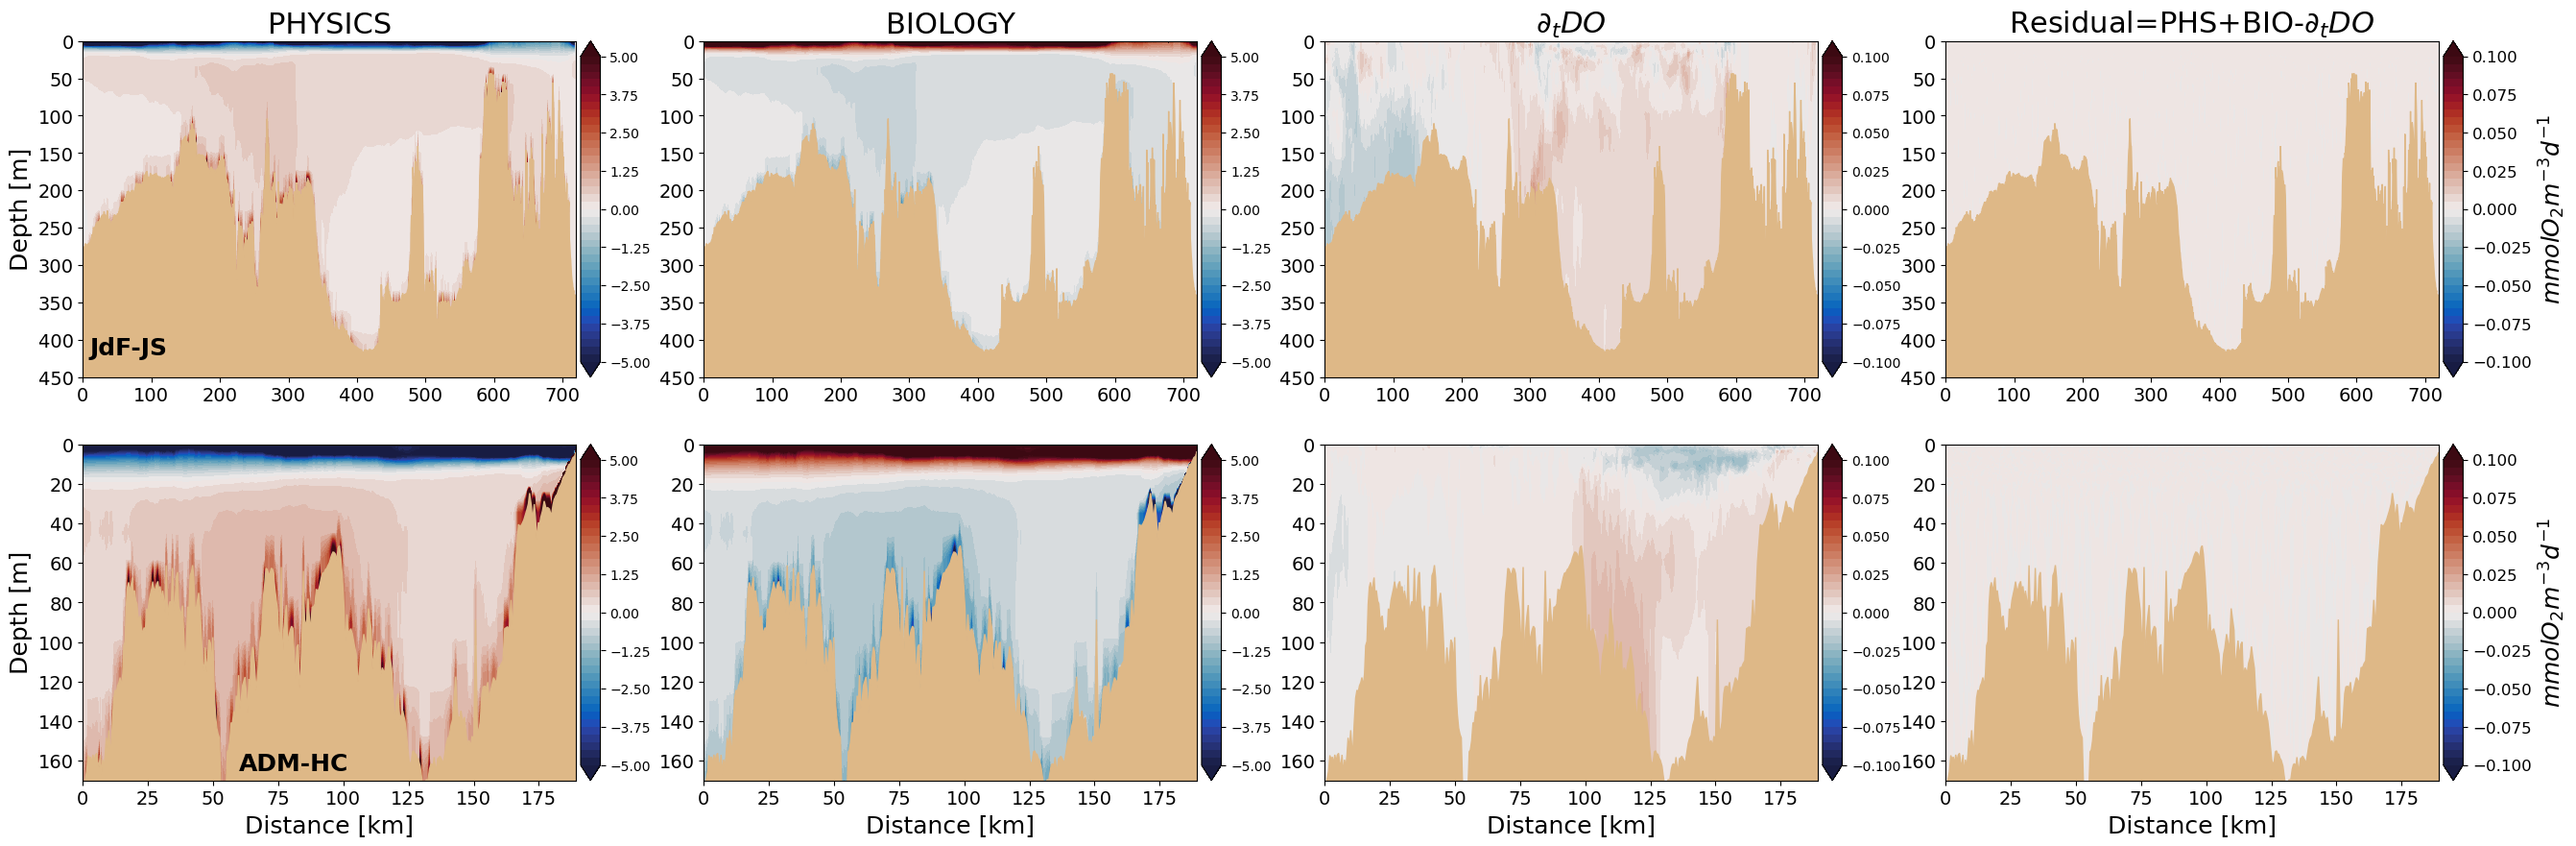

In [49]:
fig, ax = plt.subplots(row, col, figsize=(32, 10))
for j in range(row):
    for i in range(col):
        if i==0:
            var = ds_diag_clim.PHS_O2*conv
            space = np.linspace(-5, 5, 41)
        elif i==1:
            var = ds_diag_clim.BIO_O2*conv
        elif i==2:
            var = ds_diag_clim.RATE_O2*conv
            space = np.linspace(-0.1, 0.1, 41)
        elif i==3:
            var = (ds_diag_clim.PHS_O2+ds_diag_clim.BIO_O2-ds_diag_clim.RATE_O2)*conv
        dep_thal, distance, var_thal = vis.load_thalweg(depth[0, ...], np.array(var).mean(axis=0), bathy['nav_lon'][:], bathy['nav_lat'][:],thalwegs[j])
        var_plot = vis._fill_in_bathy(var_thal, mesh, thalwegs[j])
        colours_var = ax[j,i].contourf(distance, dep_thal, var_plot, space, cmap=cmap, extend='both')
        vis._add_bathy_patch(distance, bathy['Bathymetry'][:], thalwegs[j], ax[j,i], color='burlywood')
        ax[j,i].invert_yaxis()
        ax[1,i].set_xlabel('Distance [km]',fontsize=18)
        ax[j,i].set_ylim([depmin[j], 0])
        ax[j,i].tick_params(labelsize=14)
        ax[0,i].set_title(f'{title[i]}',fontsize=22)
        divider = make_axes_locatable(ax[j,i])
        cax = divider.append_axes('right', size="4%", pad=0.05)
        cbar = fig.colorbar(colours_var, cax=cax)
        if i==3:
            cbar.ax.set_ylabel(f'{label}',fontsize=18)
            cbar.ax.tick_params(labelsize='large')
    ax[j,0].set_ylabel('Depth [m]',fontsize=18)
ax[0,0].text(10,420,'JdF-JS',fontsize=18,weight='bold')
ax[1,0].text(60,165,'ADM-HC',fontsize=18,weight='bold')

#### Checking intraseasonal : 17-day - July 20 - Aug 5, 2015

Text(60, 165, 'ADM-HC')

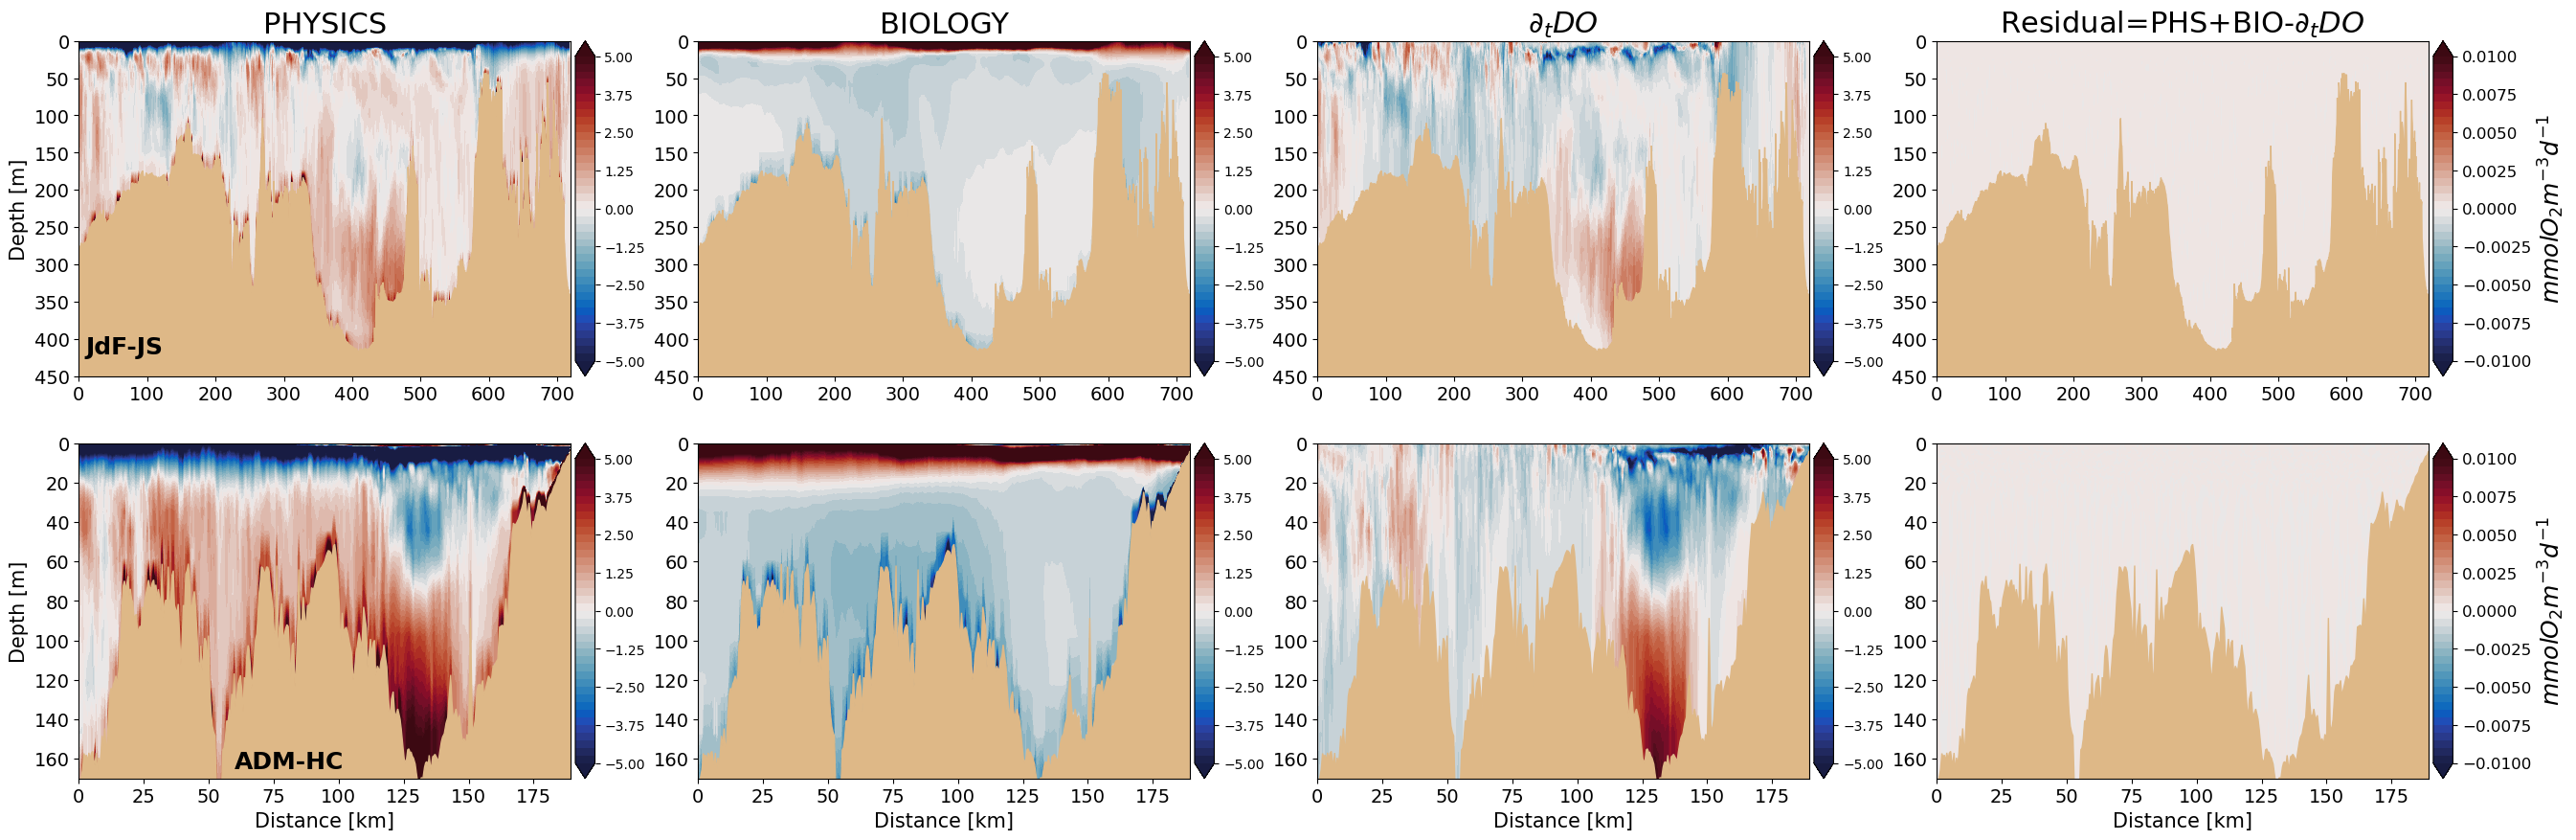

In [48]:
fig, ax = plt.subplots(row, col, figsize=(32, 10))
dir = '/ocean/atall/MOAD/Model/202410b/oxygen/'
syear, smonth, sday = (2015, 7, 20)
eyear, emonth, eday = (2015, 8, 5)
startdate = arrow.get(syear, smonth, sday)
enddate = arrow.get(eyear, emonth, eday)
for j in range(row):
    first = True
    for iii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
        year = day.year
        yr2 = day.strftime("%y")
        month = day.month
        Month = day.strftime("%b").lower()
        day = day.day
        ds_diag = xr.open_dataset(f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_diag_T.nc') 
       
        dep_thal, distance, phs_thal = vis.load_thalweg(depth[0, ...], conv*np.array(ds_diag.PHS_O2).mean(axis=0), bathy['nav_lon'][:], bathy['nav_lat'][:],thalwegs[j])
        dep_thal, distance, bio_thal = vis.load_thalweg(depth[0, ...], conv*np.array(ds_diag.BIO_O2).mean(axis=0), bathy['nav_lon'][:], bathy['nav_lat'][:],thalwegs[j])
        dep_thal, distance, rate_thal = vis.load_thalweg(depth[0, ...], conv*np.array(ds_diag.RATE_O2).mean(axis=0), bathy['nav_lon'][:], bathy['nav_lat'][:],thalwegs[j])
        if first:
            first = False
            bioTS = bio_thal
            phsTS = phs_thal
            rateTS = rate_thal
        else:
            rateTS = np.vstack((rateTS, rate_thal)) 
            bioTS = np.vstack((bioTS, bio_thal)) 
            phsTS = np.vstack((phsTS, phs_thal))
    rate = rateTS.reshape(len(rateTS)//len(ds_diag.RATE_O2['deptht']),len(ds_diag.RATE_O2['deptht']),len(thalwegs[j]))  
    bio = bioTS.reshape(len(bioTS)//len(ds_diag.RATE_O2['deptht']),len(ds_diag.RATE_O2['deptht']),len(thalwegs[j]))  
    phs = phsTS.reshape(len(phsTS)//len(ds_diag.RATE_O2['deptht']),len(ds_diag.RATE_O2['deptht']),len(thalwegs[j]))       
    for i in range (col):
        if i==0:
            var = phs
            space = np.linspace(-5, 5, 41)
        elif i==1:
            var = bio
        elif i==2:
            var = rate
        elif i==3:
            var = phs+bio-rate
            space = np.linspace(-0.01, 0.01, 41)
        var_plot = vis._fill_in_bathy(var.mean(axis=0), mesh, thalwegs[j])
        colours_var = ax[j,i].contourf(distance, dep_thal, var_plot, space, cmap=cmap, extend='both')
        vis._add_bathy_patch(distance, bathy['Bathymetry'][:], thalwegs[j], ax[j,i], color='burlywood')
        ax[j,i].invert_yaxis()
        ax[j,0].set_ylabel('Depth [m]',fontsize=15)
        ax[1,i].set_xlabel('Distance [km]',fontsize=15)
        ax[j,i].set_ylim([depmin[j], 0])
        ax[0,i].set_title(f'{title[i]}',fontsize=22)
        ax[j,i].tick_params(labelsize=14)
        divider = make_axes_locatable(ax[j,i])
        cax = divider.append_axes('right', size="4%", pad=0.05)
        cbar = fig.colorbar(colours_var, cax=cax)
        if i==3:
            cbar.ax.set_ylabel(f'{label}',fontsize=18)
            cbar.ax.tick_params(labelsize='large')
ax[0,0].text(10,420,'JdF-JS',fontsize=18,weight='bold')
ax[1,0].text(60,165,'ADM-HC',fontsize=18,weight='bold')

#### Total oxygen change: from the model equation / from DO concentration

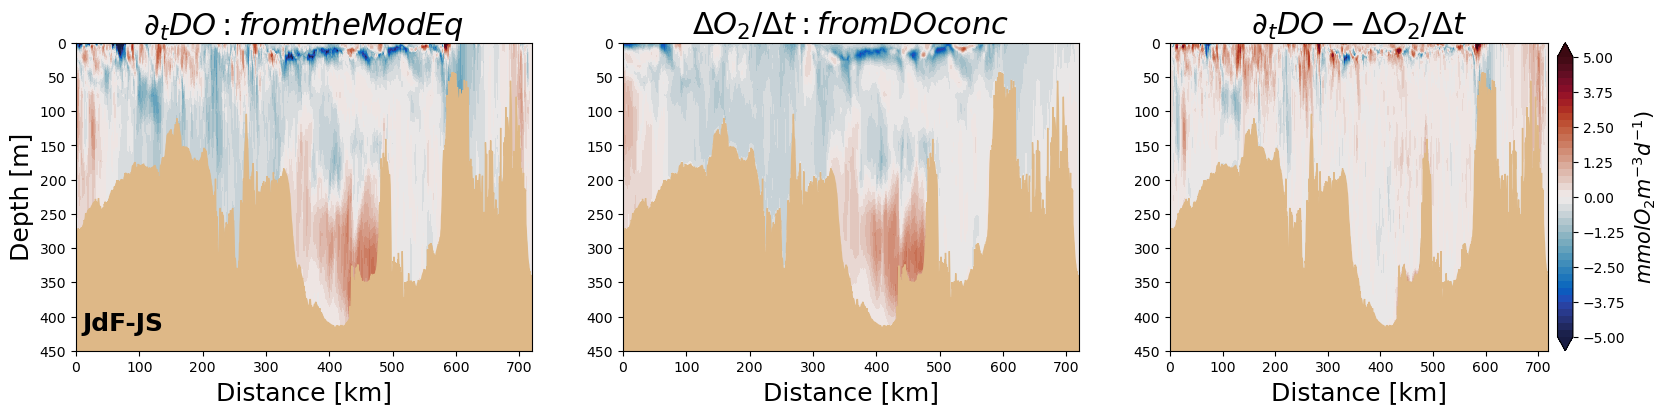

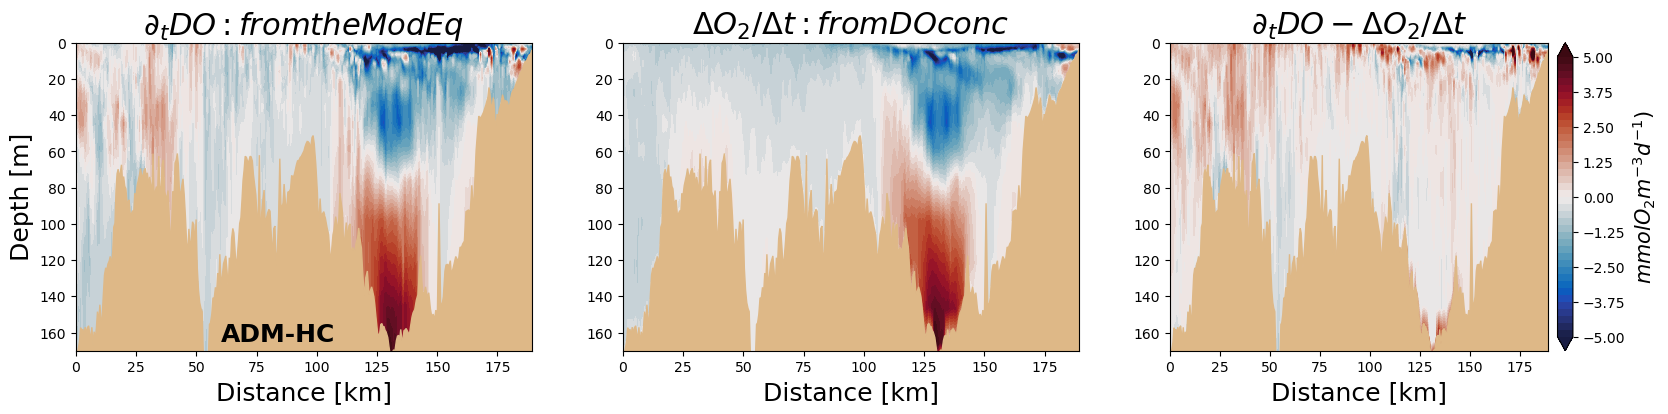

In [ ]:
titleRate = list(['$\partial _t{DO} : from the Mod Eq$','$\Delta O_2/\Delta t : from DO conc$','$\partial _t{DO} - \Delta O_2/\Delta t$'])
dir = '/ocean/atall/MOAD/Model/202410b/oxygen/'
for j in range(row):
    fig, ax = plt.subplots(1, col-1, figsize=(20, 4))
    ds_chems = xr.open_dataset(f'{dir}20jul15/SalishSea_1d_20150720_20150720_chem_T.nc')
    ds_cheme = xr.open_dataset(f'{dir}05aug15/SalishSea_1d_20150805_20150805_chem_T.nc')
    dt=17
    dep_thal, distance, dif_thal = vis.load_thalweg(depth[0, ...], np.array(ds_cheme.dissolved_oxygen[0,...]-ds_chems.dissolved_oxygen[0,...])/dt, bathy['nav_lon'][:], bathy['nav_lat'][:],thalwegs[j])
    first = True
    for iii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
        year = day.year
        yr2 = day.strftime("%y")
        month = day.month
        Month = day.strftime("%b").lower()
        day = day.day
        ds_diag = xr.open_dataset(f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_diag_T.nc') 
       
        dep_thal2, distance2, rate_thal = vis.load_thalweg(depth[0, ...], conv*np.array(ds_diag.RATE_O2).mean(axis=0), bathy['nav_lon'][:], bathy['nav_lat'][:],thalwegs[j])
        if first:
            first = False
            rateTS = rate_thal
        else:
            rateTS = np.vstack((rateTS, rate_thal)) 
    rate = rateTS.reshape(len(rateTS)//len(ds_diag.RATE_O2['deptht']),len(ds_diag.RATE_O2['deptht']),len(thalwegs[j]))   
    rate_plot = vis._fill_in_bathy(rate.mean(axis=0), mesh, thalwegs[j])
    vars = [rate_plot,dif_thal,rate_plot-dif_thal]
    for i in range(col-1):
        colours_var = ax[i].contourf(distance, dep_thal, vars[i], np.linspace(-5, 5, 41), cmap=cmap, extend='both')
        vis._add_bathy_patch(distance, bathy['Bathymetry'][:], thalwegs[j], ax[i], color='burlywood')
        ax[i].invert_yaxis()
        ax[i].set_xlabel('Distance [km]',fontsize=18)
        ax[i].set_ylim([depmin[j], 0])
        ax[i].set_title(f'{titleRate[i]}',fontsize=22)
    cbar = plt.colorbar(colours_var, ax=ax[2], pad=0.02)
    cbar.ax.set_ylabel(r'$mmolO_2m^{-3}d^{-1})$',fontsize=15)
    ax[0].set_ylabel('Depth [m]',fontsize=18)
    if j==0:
        ax[0].text(10,420,'JdF-JS',fontsize=18,weight='bold')
    else:
        ax[0].text(60,165,'ADM-HC',fontsize=18,weight='bold')